In [5]:
# 1. Setup, Imports, and Dataset Loading
import os
from dotenv import load_dotenv
from langsmith import Client, evaluate
from langchain_groq import ChatGroq
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
import nest_asyncio

# --- Configuration ---
load_dotenv()
MODEL_NAME = "llama-3.3-70b-versatile"
client = Client()
nest_asyncio.apply()

# Initialize Groq client for generation and evaluation
groq_llm = ChatGroq(model=MODEL_NAME, temperature=0)

# TWEAK: Clone a public dataset (this dataset contains transcripts)
dataset = client.clone_public_dataset(
  "https://smith.langchain.com/public/9078d2f1-7bef-4ba7-b795-210a17682ef9/d"
)
print(f"Dataset loaded: {dataset.name}")

Dataset loaded: Meeting Transcripts


In [6]:
# 2. Custom Pydantic Evaluator Setup

# Define the structured output schema for scoring
class SummarizationScore(BaseModel):
    score: int = Field(description="A score from 1-5 ranking how good the summarization is for the provided transcript, with 1 being a bad summary, and 5 being a great summary")

parser_score = PydanticOutputParser(pydantic_object=SummarizationScore)

SUMMARIZATION_SYSTEM_PROMPT = "You are a judge, aiming to score how well a summary summarizes the content of a customer service transcript. Only output a valid JSON object adhering to the schema." # TWEAK: Context change

SUMMARIZATION_HUMAN_PROMPT = """
[The Customer Service Transcript] {transcript}
[The Summary] {summary}
{format_instructions}
"""

score_prompt = PromptTemplate(
    template=SUMMARIZATION_SYSTEM_PROMPT + "\n\n" + SUMMARIZATION_HUMAN_PROMPT,
    input_variables=["transcript", "summary"],
    partial_variables={"format_instructions": parser_score.get_format_instructions()},
)

# Function to run evaluation score
def summary_score_evaluator(inputs: dict, outputs: dict) -> dict:
    try:
        # Construct the full prompt for the LLM Judge
        full_prompt = score_prompt.format(
            transcript=inputs["transcript"],
            summary=outputs.get("output", "N/A")
        )
        # Invoke Groq for structured output (LLM-as-Judge)
        judge_chain = groq_llm | parser_score
        result = judge_chain.invoke(full_prompt)
        score = result.score
    except Exception as e:
        print(f"Evaluator failed: {e}")
        score = 1 # Assign a low score on failure

    # Format the score for Langsmith
    return {"key": "summary_score", "score": score}

In [7]:
# 3. Running Experiment 1: Good Summarizer

# Prompt One: Good Prompt
def good_summarizer(inputs: dict):
    response = groq_llm.invoke(
        f"Concisely summarize this customer service transcript in 3 sentences. Focus on the final resolution. Transcript: {inputs['transcript']}" # TWEAK: Custom prompt and context
    )
    return response.content

# TWEAK: Custom Experiment Prefix
print("Starting Good Summarizer Experiment (Groq CS)...")
good_experiment = client.evaluate(
    good_summarizer,
    data=dataset,
    evaluators=[summary_score_evaluator],
    experiment_prefix="Groq-CS-Good-Summarizer-Tweak"
)
print(f"Good Experiment Name: {good_experiment.experiment_name}")

Starting Good Summarizer Experiment (Groq CS)...
View the evaluation results for experiment: 'Groq-CS-Good-Summarizer-Tweak-291f4c74' at:
https://smith.langchain.com/o/6072fe80-253a-475b-81f3-74f20971421c/datasets/0c88bdc3-40e6-4c90-a1d7-001b0b52e339/compare?selectedSessions=d3d84c23-2567-4cbd-bdb4-a7f237f80095




5it [00:04,  1.17it/s]

Good Experiment Name: Groq-CS-Good-Summarizer-Tweak-291f4c74


In [8]:
# 4. Running Experiment 2: Bad Summarizer

# Prompt Two: Worse Prompt!
def bad_summarizer(inputs: dict):
    response = groq_llm.invoke(
        f"Summarize this entire transcript in one very short sentence. Include no specific details. Transcript: {inputs['transcript']}" # TWEAK: Custom prompt
    )
    return response.content

# TWEAK: Custom Experiment Prefix
print("\nStarting Bad Summarizer Experiment (Groq CS)...")
bad_experiment = client.evaluate(
    bad_summarizer,
    data=dataset,
    evaluators=[summary_score_evaluator],
    experiment_prefix="Groq-CS-Bad-Summarizer-Tweak"
)
print(f"Bad Experiment Name: {bad_experiment.experiment_name}")


Starting Bad Summarizer Experiment (Groq CS)...
View the evaluation results for experiment: 'Groq-CS-Bad-Summarizer-Tweak-7abd520d' at:
https://smith.langchain.com/o/6072fe80-253a-475b-81f3-74f20971421c/datasets/0c88bdc3-40e6-4c90-a1d7-001b0b52e339/compare?selectedSessions=8f933b0c-9e69-4fae-bbf7-f164437ce4b8




5it [00:02,  1.67it/s]

Bad Experiment Name: Groq-CS-Bad-Summarizer-Tweak-7abd520d


In [9]:
# 5. Pairwise Evaluator Definition

class Preference(BaseModel):
    preference: int = Field(description="1 if Assistant A answer is better. 2 if Assistant B answer is better. 0 if it is a tie.")
    
parser_preference = PydanticOutputParser(pydantic_object=Preference)

JUDGE_SYSTEM_PROMPT = """
Please act as an impartial judge and evaluate the quality of the summarizations provided by two AI summarizers to the customer service transcript below. 
Your evaluation should consider factors such as the helpfulness, relevance, accuracy, and detail of their summarizations. 
Begin your evaluation by comparing the two summarizations and provide a short explanation. 
Only output a valid JSON object adhering to the schema.
"""
JUDGE_HUMAN_PROMPT = """
[The Customer Service Transcript] {transcript}\n
[Assistant A's Summarization] {answer_a}\n
[Assistant B's Summarization] {answer_b}\n
{format_instructions}
"""

def ranked_preference(inputs: dict, outputs: list[dict]) -> list:
    # This function compares two experiment outputs
    full_prompt = PromptTemplate(
        template=JUDGE_SYSTEM_PROMPT + "\n\n" + JUDGE_HUMAN_PROMPT,
        input_variables=["transcript", "answer_a", "answer_b"],
        partial_variables={"format_instructions": parser_preference.get_format_instructions()},
    ).format(
        transcript=inputs["transcript"],
        answer_a=outputs[0].get("output", "N/A"),
        answer_b=outputs[1].get("output", "N/A")
    )
    
    # Invoke Groq for structured output
    judge_chain = groq_llm | parser_preference
    try:
        result = judge_chain.invoke(full_prompt)
        preference_score = result.preference
    except Exception:
        preference_score = 0 # Assign tie on failure

    # Format the score [A Score, B Score]
    if preference_score == 1:
        scores = [1, 0]
    elif preference_score == 2:
        scores = [0, 1]
    else:
        scores = [0, 0]
    return scores

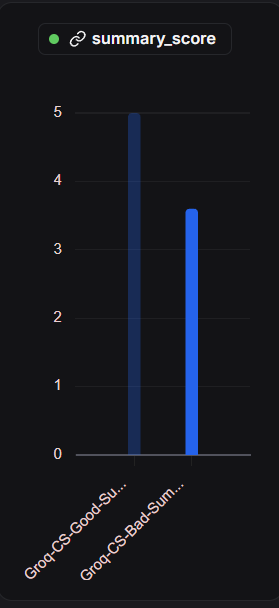